In [1]:
import numpy as np
from numpy import interp
from scipy import signal

from matplotlib import pyplot as plt

In [2]:
from matplotlib.patches import FancyArrow
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.gridspec as gridspec

## Signal Processing

A pedogogical introduction to signal processing is beyond the scope for this course, so we're only going to cover the very basics and blitz through the material so we can get to some interesting stuff.  I **highly** encourage you to spend time working through the complete material in [José Unpingco's repository](https://github.com/unpingco/Python-for-Signal-Processing) (which this is a small selection of) for a more complete introduction to signal processing.

## Fourier Transform

I'm assuming that you've seen [Fourier transforms](https://en.wikipedia.org/wiki/Fourier_transform) at one point or another, so we won't spent much time reviewing it.  In short, the Fourier transform of some function $x(t)$ takes the form:

$$
\tilde{x}(f) = \int_{-\infty}^\infty x(t) e^{-2\pi i f t}dt,
$$

and the inverse Fourier transform:

$$
x(t) = \int_{-\infty}^\infty \tilde{x}(f)e^{2\pi i f t}df.
$$

Related to this is the Fourier series:


$$
x(t) = \sum_j a_j e^{2\pi i \frac{j}{T} t}.
$$

a series expansion of any periodic function in terms of Fourier coefficients:

$$
a_j = \frac{1}{T}\int_{0}^{T}y(t)e^{-2\pi i \frac{j}{T}t}dt = \frac{1}{T}\tilde{y}\left(\frac{j}{T}\right)
$$



Notice that a single point $a_j$ in Fourier space involves an integral over the entire signal in the time domain.

**NOTE ON UNITS**

When attaching units to the quantities we identified as $t$ and $f$, the relations above require $f$ to have inverse units of $t$.  Thus if $t$ has units of seconds, $f$ must have units of cycles per second.  Physicists often work in angular frequency $\omega$, which is related to frequency by $\omega = 2\pi f$.  So you will often see this change of variables to the transforms shown above.

$$
\tilde{x}(\omega) = \int_{-\infty}^\infty x(t) e^{-i \omega t}dt,
$$

$$
x(t) = \frac{1}{2\pi} \int_{-\infty}^\infty \tilde{x}(\omega)e^{i \omega t}d\omega.
$$


## Discrete sampling and finite duration

Let's start off with Shannon's Sampling Theorem:
```
If a function x(t) contains no frequencies higher than B hertz, it is completely
determined by giving its ordinates at a series of points spaced 1/(2B) seconds apart.
```

Since real life will always have us working with data of finite duration with a finite sampling rate, let's dig into how these affect Fourier analysis.

First let's establish the limitations of a signal sampled with finite frequency.  According to the [sampling theorem](https://en.wikipedia.org/wiki/Nyquist%E2%80%93Shannon_sampling_theorem), we can't sample a periodic signal at a frequency less than half of the signal's frequency (referred to as the Nyquist frequency).

![sampling theorem](https://upload.wikimedia.org/wikipedia/commons/thumb/a/af/CPT-sound-nyquist-thereom-1.5percycle.svg/459px-CPT-sound-nyquist-thereom-1.5percycle.svg.png)

Consider a sinusoidal function with a frequency of 1 Hz sampled 20 times per second.

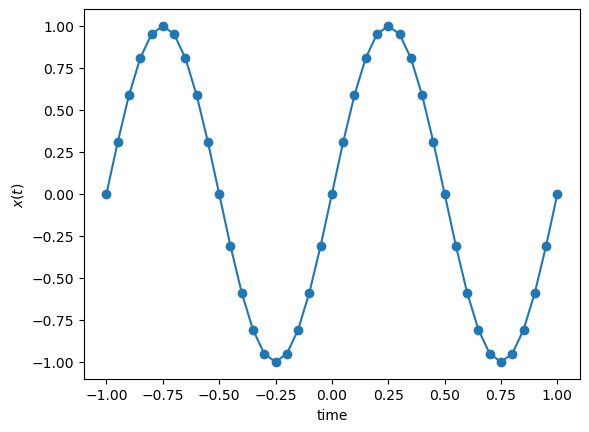

In [3]:
f = 1.0 # 1 Hz signal frequency
fs = 20.0 # 20 samples per second

sample_t = np.arange(-1, 1+1/fs, 1/fs)
sample_x = np.sin(2*np.pi*f*sample_t)

plt.plot(sample_t, sample_x, marker='o')
plt.xlabel('time')
plt.ylabel('$x(t)$');

Let's zoom into one of the peaks.

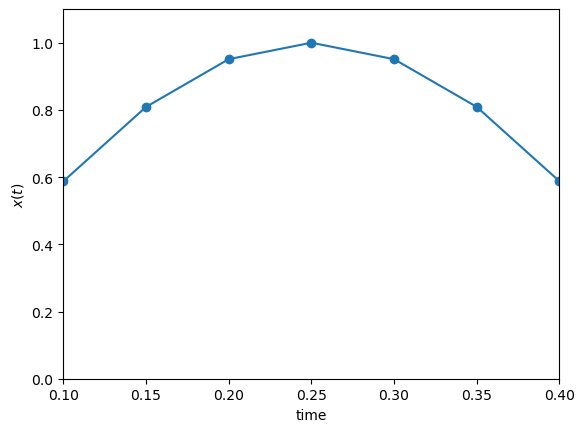

In [4]:
plt.plot(sample_t, sample_x, marker='o')
plt.xlabel('time')
plt.ylabel('$x(t)$')
plt.xlim(1/(4*f) - 1/fs*3, 1/(4*f) + 1/fs*3)
plt.ylim(0, 1.1);

This should trigger memories of our study of interpolation techniques.  Recall that `matplotlib` implicitly draws between data between points using *linear interpolation*.

Let's look at how the error of this interpolation from the true underlying function looks by calculating error over 20 points between each existing sample.

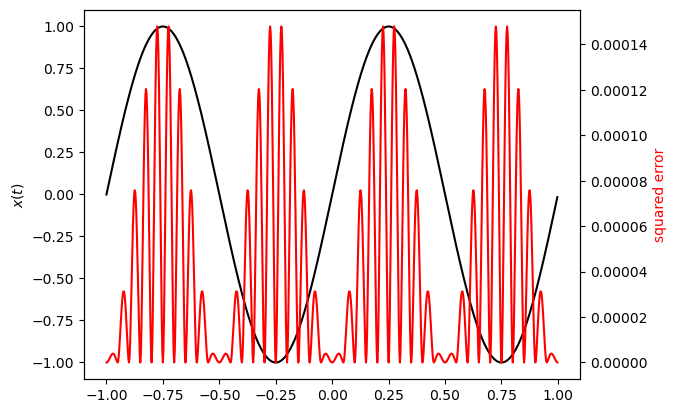

In [5]:
high_res_t = np.array([np.linspace(sample_t[i], sample_t[i+1], 20, False) for i in range(len(sample_t) - 1)]).flatten()
high_res_x = np.sin(2*np.pi*f*high_res_t)

interp_x = interp(high_res_t, sample_t, sample_x)
sq_error = (high_res_x - interp_x)**2

ax1 = plt.figure().add_subplot(111)
ax1.plot(high_res_t, high_res_x, color='k')

ax2 = ax1.twinx()
ax2.plot(high_res_t, sq_error, color='r')

plt.xlabel('time')
ax1.set_ylabel('$x(t)$')
ax2.set_ylabel('squared error', color='r')

# save error limits for later
error_bound = plt.ylim()[1];

## Bandlimited signal

Now let's look at consider a bandlimited signal, a signal which has finite width in the frequency domain, where

$$
\tilde{x}(f) = 0~~~\mathrm{where}~|f| > W
$$

The inverse Fourier transform of this signal is

$$
x(t) = \int_{-W}^{W}\tilde{x}(f)e^{2\pi i f t}df
$$

If we pretend the signal is periodic with period $2W$, we can expand it into a Fourier series

$$
\tilde{x}(f) = \sum_k a_k e^{-2\pi i kf/(2W)}
$$

We can calculate the coefficients

$$
a_k = \frac{1}{2W}\int_{-W}^{W}\tilde{x}(f)e^{2\pi i kf/(2W)}df = \frac{1}{2W}x\left(t=\frac{k}{2W}\right)
$$

So plugging in our expression for $\tilde{x}(f)$ into the expression for $x(t)$

$$
x(t) = \int_{-W}^{W}\sum_k a_k e^{-2\pi i k f/(2W)}e^{2\pi if t}df
$$

and plugging in the expression for the $a_k$

$$
\begin{align}
x(t) &= \int_{-W}^{W}\sum_k \frac{1}{2W}x\left(t=\frac{k}{2W}\right) e^{-2\pi i k f/(2W)}e^{2\pi if t}df \\
&= \sum_k \frac{1}{2W}x\left(t=\frac{k}{2W}\right) \int_{-W}^{W} e^{-2\pi i f( k/(2W)+ t)}df \\
&= \sum_k x\left(t=\frac{k}{2W}\right) \frac{\sin(\pi(k - 2tW))}{\pi(k-2tW)}
\end{align}
$$

You may recognize the $\mathrm{sinc}$ function in this expression:
$$
\mathrm{sinc}(x) = \frac{\sin x}{x}
$$

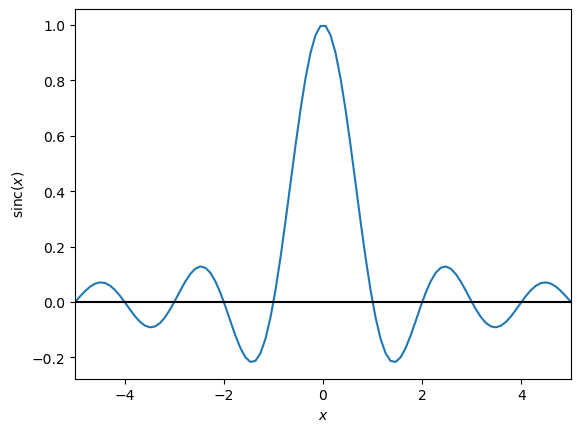

In [6]:
y = np.linspace(-5, 5, 100)
plt.plot(y, np.sinc(y))
plt.axhline(0, color='k')
plt.xlim(-5, 5)
plt.xlabel('$x$')
plt.ylabel('$\mathrm{sinc}(x)$');

We now have a way to reconstruct a function from it's samples (i.e., interpolate).  Since our samples are spaced in time according to $t=k/f_s$, let's use $W=f_s/2$.

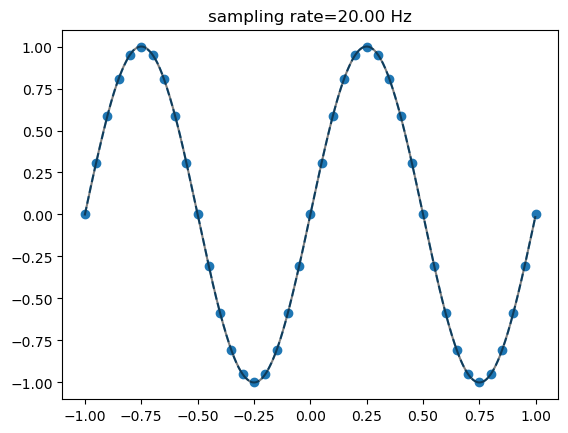

In [7]:
num_coeffs = len(sample_t) 

sm = 0
for k in range(-num_coeffs, num_coeffs): # since function is real, we need both sides
    sm += np.sin(2*np.pi*(k/fs))*np.sinc(k - fs * high_res_t)

plt.scatter(sample_t, sample_x)

plt.plot(high_res_t, sm, ls='--')
plt.plot(high_res_t, high_res_x, color='k', alpha=0.5)

plt.title('sampling rate=%3.2f Hz' % fs );

How is the error?

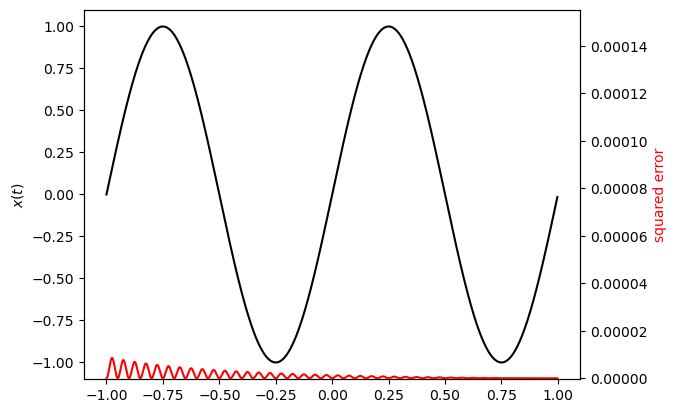

In [8]:
sq_error = (high_res_x - sm)**2

ax1 = plt.figure().add_subplot(111)
ax1.plot(high_res_t, high_res_x, color='k')

ax2 = ax1.twinx()
ax2.plot(high_res_t, sq_error, color='r')

plt.xlabel('time')
ax1.set_ylabel('$x(t)$')
ax2.set_ylabel('squared error', color='r')

plt.ylim(top=error_bound);

Much better!  This interpolation technique is known as the [Whittaker-Shannon Interpolation Formula](https://en.wikipedia.org/wiki/Whittaker%E2%80%93Shannon_interpolation_formula).  But, there is still some error, and this seems to go against the sampling theorem.  What gives? We'll get to that in a minute.

Let's use a lower sampling rate and see how these terms actually stack up.

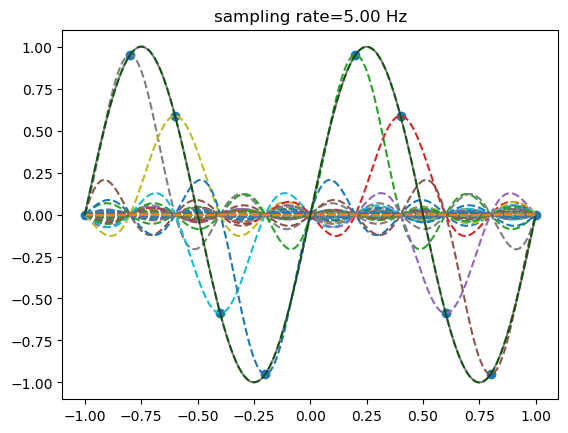

In [9]:
fs = 5.0 # 5 samples per second

sample_t = np.arange(-1, 1+1/fs, 1/fs)
sample_x = np.sin(2*np.pi*f*sample_t)

plt.scatter(sample_t, sample_x)

sm = np.zeros(len(high_res_t))
for k in range(-num_coeffs, num_coeffs): # since function is real, we need both sides
    term = np.sin(2*np.pi*(k/fs))*np.sinc(k - fs * high_res_t)
    plt.plot(high_res_t, term, ls='--')
    sm += term

plt.plot(high_res_t, sm, ls='--')
plt.plot(high_res_t, high_res_x, color='k', alpha=0.5)

plt.title('sampling rate=%3.2f Hz' % fs );

Ok, so why are we still seeing non-zero errors?  Let's take another look at the $\mathrm{sinc}$ function, but over a wider domain.

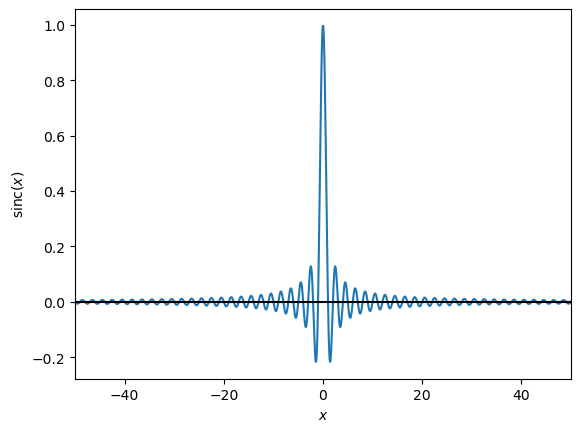

In [10]:
y = np.linspace(-50, 50, 1000)
plt.plot(y, np.sinc(y))
plt.axhline(0, color='k')
plt.xlim(-50, 50)
plt.xlabel('$x$')
plt.ylabel('$\mathrm{sinc}(x)$');

The $\mathrm{sinc}$ function extends to infinity in both directions, meaning the signal we can represent with it must also extend to infinity.  So the sampling theorem allows us to reconstruct a function with *sparse* samples, but we need to sample *forever*.

Let's try to develop some intuition for how this stuff works with finite-duration signals.

## Approximately Time-Limited Signals

Let's consider a signal that's *almost* time-limited, meaning *almost* all of it's energy is concentrated in a finite time window

$$
\int_{-\tau}^{\tau} |f(t)|^2dt = E - \epsilon,
$$

where the total energy of the signal is

$$
\int_{-\infty}^{\infty} |f(t)|^2dt = E.
$$

Now let's seek functions $\phi(t)$ that are band-limited, but come within $\epsilon$ of being time-limited as well:

$$
\phi(t) = \int_{-W}^{W}\tilde{\phi}(\nu)e^{2\pi i\nu t}dt
$$

and maximize the quantity:

$$
\int_{-\tau}^{\tau}|\phi(t)|^2dt.
$$

It turns out this (eventually) leads you to the following [eigenvalue equation](https://en.wikipedia.org/wiki/Eigenvalues_and_eigenvectors):

$$
\int_{-\tau}^{\tau}\phi(x)\frac{\sin(2\pi W(t - x))}{\pi(t-x)}dx = \lambda \phi(t),
$$

and the set of $\phi_k(t)$ eigenfunctions form the basis for arbitrary almost-time-limited functions:

$$
f(t) = \sum_k a_k \phi_k(t),
$$

where $\phi_k(t)$ aren't time-limited, but *time-concentrated* over the interval $[-\tau, \tau]$.

Finally, let's do a change of variables to get this into a normalized form

$$
\int_{-1}^{1} \psi(x)\frac{\sin(2\pi\sigma(t-x)/4)}{\pi(t-x)}dx = \lambda \psi(t),
$$

where we've defined $\sigma = (2\tau)(2W)$, which is the *time-bandwidth product*.  It turns out that this is a familiar problem (in certain circles) whose solutions for the $\psi$ functions turn out to be [prolate spheroidal wave functions](https://en.wikipedia.org/wiki/Prolate_spheroidal_wave_function).  Let's see what the solutions look like.

First we'll define a function for convenience, which computes the kernel of an eigenvalue problem.

In [11]:
def kernel(x, sigma=1):
    x = np.asanyarray(x)
    y = np.pi * np.where(x == 0, 1.0e-20, x)
    return np.sin(sigma/2*y)/y

Now let's see how the eigenvalues change as a function of the time-bandwidth product $\sigma = (2\tau)(2W)$.  This will involve integrals over time, which we'll do quick-and-dirty.  We'll focus on the largest eigenvalue, as it represents the fraction of the energy contained in the interval $[-1, 1]$.

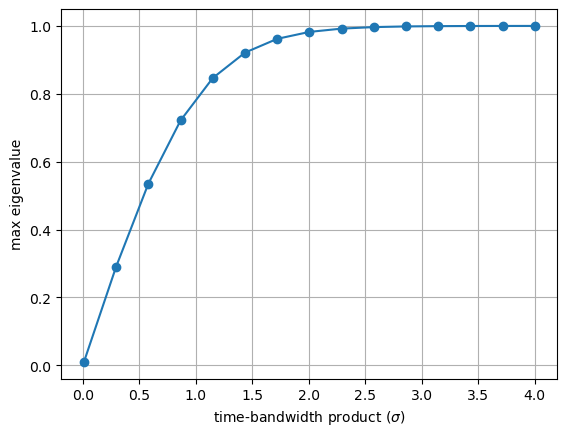

In [12]:
# setup for time integral
nstep = 100
t = np.linspace(-1, 1, nstep)
dt = np.diff(t)[0]

# compute max eigenvalue
def eigv(sigma):
    return np.linalg.eigvalsh(kernel(t - t[:, None], sigma)).max()

# consider time-bandwidth products over the following range
sigma = np.linspace(0.01, 4, 15) 

plt.plot(sigma, dt*np.array([eigv(i) for i in sigma]),'-o')
plt.xlabel('time-bandwidth product ($\sigma$)')
plt.ylabel('max eigenvalue')
plt.grid()

This shows that for $\sigma > 3$, $\psi_0(t)$ is the eigenfunction that is most concentrated in that interval.

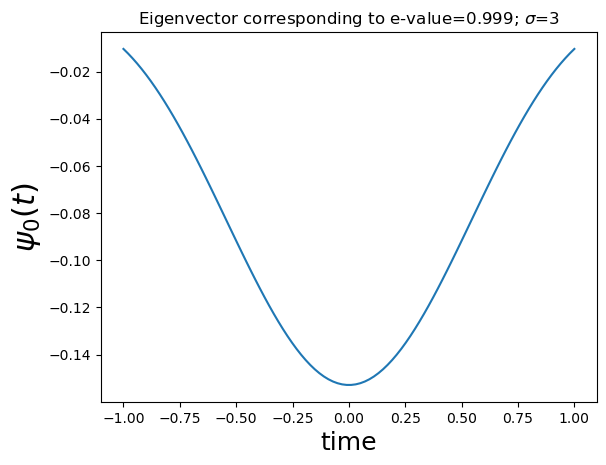

In [13]:
sigma = 3
w, v = np.linalg.eigh(kernel(t - t[:, None], sigma))
maxv = v[:, w.argmax()]

plt.plot(t, maxv)
plt.xlabel('time',fontsize=18)
plt.ylabel('$\psi_0(t)$',fontsize=22)
plt.title('Eigenvector corresponding to e-value={:.3f}; $\sigma$={}'.format(w.max()*dt, sigma));

We will see this shape again if we make it to talking about window functions.

So to reiterate, we have made a connection between the quality of our reconstruction using the Whittaker interpolant, and the details of our finite sample, specifically the time-bandwidth product.

Before we move on, let's return to the original formulation in terms of $\tau$ and $W$

$$
\int_{-\tau}^{\tau}\phi(x)\frac{\sin(2\pi W(t - x))}{\pi(t-x)}dx = \lambda\phi(t)
$$

and re-solve the eigenvalue problem.

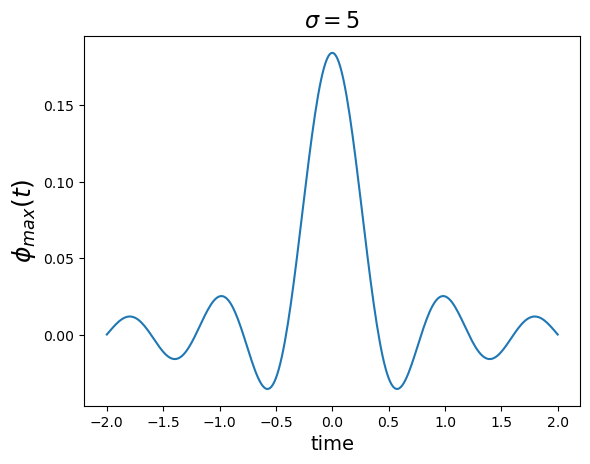

In [14]:
def kernel_tau(x, W=1):
    x = np.asanyarray(x)
    y = np.pi * np.where(x==0, 1.0e-20, x)
    return np.sin(2*W*y)/y

# Another crude integral
nstep = 300
t = np.linspace(-1, 1, nstep)
tt = np.linspace(-2, 2, nstep) # extend interval

sigma = 5
W = sigma/2./2./t.max()

w, v = np.linalg.eig(kernel_tau(t - tt[:, None], W))
ii = np.argsort(w.real) 
maxv = v[:, w.real.argmax()].real

plt.plot(tt, maxv/np.sign(maxv[nstep//2])) # normalize to keep orientation upwards
plt.xlabel('time',fontsize=14)
plt.ylabel(r'$\phi_{max}(t)$',fontsize=18)
plt.title('$\sigma=%d$'%(2*W*2*t.max()),fontsize=16);


which is starting to look like a $\mathrm{sinc}$ function.  It turns out that in the limit $\sigma \to \infty$, the eigenvalues become time-shifted $\mathrm{sinc}$ functions, which are the same used in the Whittaker interpolant.  So we can now justify it's use for large $\sigma$ values.

# Discrete Fourier Transform

The Fourier transforms we discussed a while ago apply to continuous functions, but as we've just spent a lot of time understanding, in practice we have to work with discretely sampled signals.  This calls for a *Discrete Fourier Transform* (DFT).

Since we've been using matrices a lot with machine learning, we'll use matrix notation to develop a little intuition for the DFT.

First we need to define the DFT matrix

$$
\mathbf{U} : U_{n k} =  \frac{1}{\sqrt{N}}\left[\exp\left(i\frac{2\pi}{N}nk\right)\right]_{n\in \{0,\ldots,N_s-1\},k\in\{0, \ldots,N-1\}},
$$

where $n$ indicates the row through the number of samples in the DFT and $k$ indexes the discrete frequencies as columns.

In [15]:
def dftmatrix(Nfft=32, N=None):
    k = np.arange(Nfft)
    if N is None:
        N = Nfft
    n = np.arange(N)
    U = np.matrix(np.exp(1j* 2*np.pi/Nfft * k * n[:, None])) # use numpy broadcasting to create matrix
    return U/np.sqrt(Nfft)

Recall that, given a finite sampling rate $f_s$, we can't decode any information about frequencies above $f_s/2$ in the signal.  Thus our frequency decomposition is bounded by $f=0$ from below and $f=f_s/2$ from above.  We can project this range over a unit circle to help build our intuition. 

Let's construct a 16-sample example.

In [16]:
Nfft = 16
v = np.ones((16, 1))
U = dftmatrix(Nfft=Nfft, N=16)
U.shape

(16, 16)

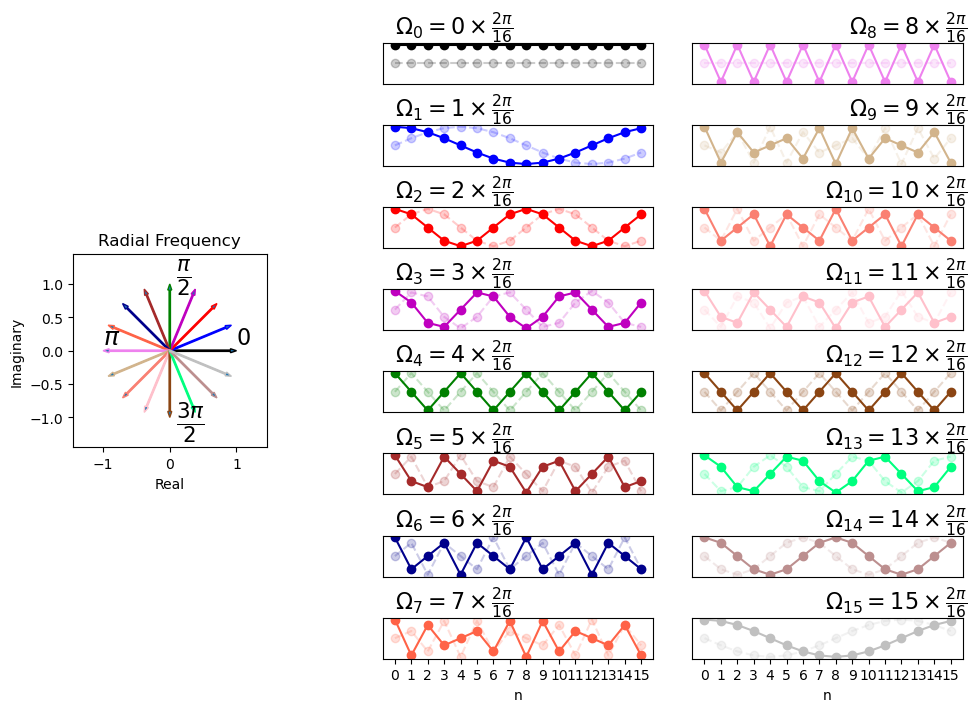

In [17]:
gs = gridspec.GridSpec(8, 12)
gs.update(wspace=1, hspace=1, left=0.01)

fig = plt.figure(figsize=(10, 8))
ax0 = plt.subplot(gs[:, :3])
fig.add_subplot(ax0)

ax0.set_aspect(1)
a=2*np.pi/Nfft*np.arange(Nfft)

colors = ['k', 'b', 'r', 'm', 'g', 'Brown', 'DarkBlue', 'Tomato',
          'Violet', 'Tan', 'Salmon', 'Pink', 'SaddleBrown', 'SpringGreen',
          'RosyBrown','Silver']

for j, i in enumerate(a):
    ax0.add_patch(FancyArrow(0, 0, np.cos(i), np.sin(i), width=0.02,
                             length_includes_head=True, edgecolor=colors[j]))

ax0.text(1, 0.1, '0', fontsize=16)
ax0.text(0.1, 1, r'$\frac{\pi}{2}$', fontsize=22)
ax0.text(-1, 0.1, r'$\pi$', fontsize=18)
ax0.text(0.1, -1.2, r'$\frac{3\pi}{2}$', fontsize=22)
ax0.axis(np.array([-1, 1, -1, 1]) * 1.45)
ax0.set_title('Radial Frequency')
ax0.set_xlabel('Real')
ax0.set_ylabel('Imaginary')

# plots in the middle column
for i in range(8):
    ax=plt.subplot(gs[i, 4:8])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(0, .4, r'$\Omega_{}={}\times\frac{{2\pi}}{{16}}$'.format(i, i),
                  fontsize=16)
    ax.plot(U.real[:, i], '-o', color=colors[i])
    ax.plot(U.imag[:, i], '--o', color=colors[i], alpha=0.2)
    ax.axis(ymax=4/Nfft*1.1, ymin=-4/Nfft*1.1)
ax.set_xticks(np.arange(16))
ax.set_xlabel('n')

# plots in the far right column
for i in range(8):
    ax=plt.subplot(gs[i, 8:])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.text(Nfft, .4, r'$\Omega_{{{}}}={}\times\frac{{2\pi}}{{16}}$'.format(i+8, i+8),
            horizontalalignment='right', fontsize=16)
    ax.plot(U.real[:, i+8], '-o', color=colors[i+8])
    ax.plot(U.imag[:, i+8], '--o', color=colors[i+8], alpha=0.2)
    ax.axis(ymax=4/Nfft * 1.1, ymin=-4/Nfft*1.1)    
    ax.yaxis.set_label_position('right')
ax.set_xticks(np.arange(16))
ax.set_xlabel('n');

On the left we have the discrete frequencies corresponding to each column in the $\mathbf{U}$ matrix.  On the right are the corresponding discrete frequencies for the $16$ samples given, with the real part in bold and the imaginary as semi-transparent (notice they're identical, but phase-shifted).  Also notice how $\Omega_1$ and $\Omega_{15}$ are complex conjugates of each other.

The rows of the matrix correspond to the sample index given a particular sampling frequency $f_s$.  So if we have $N_s$ samples, then the duration in time of the sampling is $N_s/f_s$.  If we aren't given the sampling frequency, then we can't say anything about time, and we work in *discrete frequency* (between $0$ and $2\pi$).  For a discrete index $k$, the discrete frequency follows

$$
\Omega_k = \frac{2\pi}{N}k
$$

and sampled frequency follows

$$
f_k = \frac{f_s}{N}k.
$$

So note that $\Omega_k$ is periodic with period $N$, corresponding to one trip around the circle in the figure above.  Also notice that when $k=N/2$, $\Omega_{N/2} = \pi$ (i.e., halfway around the circle), and $f_{N/2} = f_s/2$, which we've already said is the Nyquist frequency.

## Computing the DFT

We can peform a DFT using the DFT matrix defined above in the following way:

$$
\mathbf{\tilde{x}} = \mathbf{U}^H\mathbf{x},
$$

which is taking individually the inner product of $\mathbf{x}$ and columns of $\mathbf{U}$ as the $i^\mathrm{th}$ entry.

$$
\mathbf{\tilde{x}_i} = \mathbf{u}_i^H\mathbf{x}.
$$

We can get back to the original input by doing

$$
\mathbf{x} = \mathbf{U}\mathbf{U}^H\mathbf{x}
$$

Let's consider the following 16-sample signal.

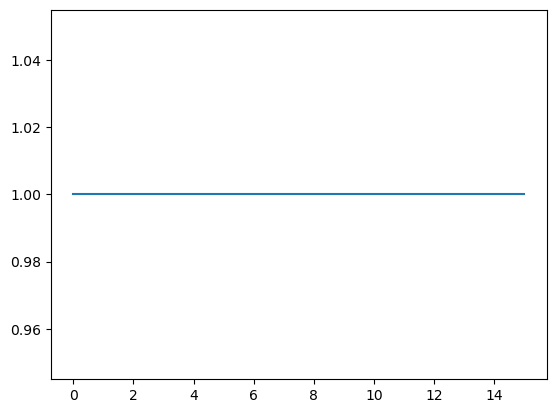

In [18]:
x = np.ones((16, 1))

plt.plot(x)

The only requirement for the size of the DFT $N$, is that $N\geq N_s$.  For now let's focus on the case where $N$ is much larger than $N_s$.

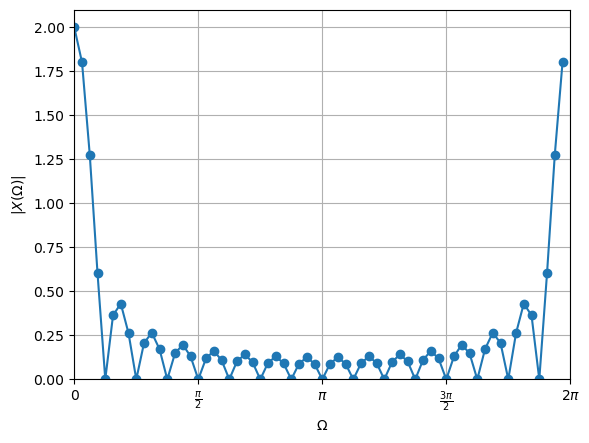

In [19]:
Nfft = 64

U = dftmatrix(Nfft, x.shape[0])
X = U.H*x

plt.plot(np.arange(0, Nfft)*2*np.pi/Nfft, np.abs(X), marker='o')

plt.xlabel(r'$\Omega$')
plt.ylabel(r'$|X(\Omega)|$')

plt.xlim(0, 2*np.pi)
plt.ylim(0, 2.1)

plt.xticks([0, np.pi/2., np.pi, 3*np.pi/2, 2*np.pi])
plt.gca().set_xticklabels(['0',r'$\frac{\pi}{2}$', r'$\pi$',r'$\frac{3\pi}{2}$', r'$2\pi$'])
plt.grid();

This looks kind of like a $\mathrm{sinc}$ function again.  But above didn't we use $\mathbf{x} = \mathbf{1}$; isn't this just a column of the $\mathbf{U}$ matrix?  The columns are supposed to be orthonormal, so why is there more than one non-zero point here?

The DFT matrix has shape `(64, 16)`, meaning that we had

$$
\mathbf{U}^H_{16\times64}\mathbf{x} = \mathbf{U}^H_{64\times64}[\mathbf{x}, \mathbf{0}]^T,
$$

effectively filling the original `(16,1)` vector $\mathbf{x}$ with zeros and using a larger compatible $\mathbf{U}_{64\times64}$.

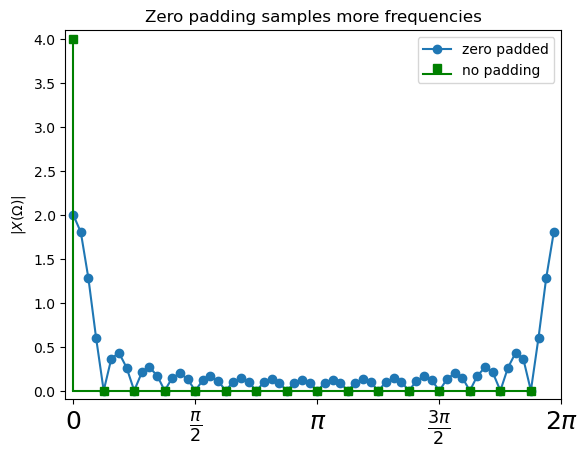

In [20]:
plt.plot(np.arange(Nfft)*2*np.pi/Nfft, np.abs(X), marker='o', label='zero padded')

new_U = dftmatrix(x.shape[0])
non_padded_X = new_U.H * x

plt.stem(np.arange(x.shape[0])*2*np.pi/x.shape[0], np.abs(non_padded_X),
         markerfmt='gs', basefmt='g-', linefmt='g-', label='no padding')

plt.ylabel(r'$|X(\Omega)|$')

plt.xlim([-.1, 2*np.pi])
plt.ylim([-.1,4.1])

plt.xticks([0, np.pi/2., np.pi, 3*np.pi/2,2*np.pi])
plt.legend(loc='upper right')

plt.gca().set_xticklabels(['0',r'$\frac{\pi}{2}$', r'$\pi$',r'$\frac{3\pi}{2}$', r'$2\pi$'],
                   fontsize=18);
plt.title('Zero padding samples more frequencies');

So without implicitly zero-padding, $\mathbf{x}$ is the $0^\mathrm{th}$ column of the 16-point DFT matrix, and so all coefficients exept the $0^\mathrm{th}$ column are 0 due to orthonormality.

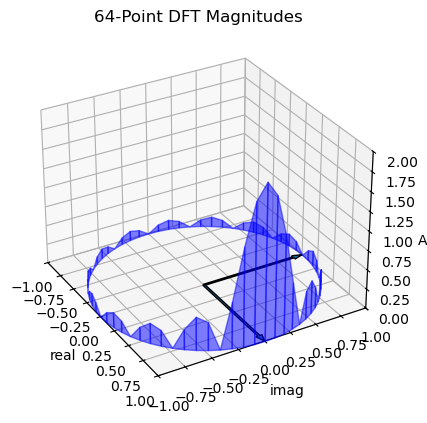

In [21]:
a = 2*np.pi/Nfft * np.arange(Nfft)
d = np.vstack([np.cos(a), np.sin(a), np.array(np.abs(X)).flatten()]).T

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.axis([-1, 1, -1, 1, -1, 1])
ax.set_zlim([0, d[:,2].max()])
# ax.set_aspect(1)
ax.view_init(azim=-30)

ax.set_xlabel('real')
ax.set_ylabel('imag')
ax.set_zlabel('Abs')
ax.set_title('64-Point DFT Magnitudes')

def facet_filled(x,alpha=0.5,color='b'):
    'construct 3D facet from adjacent points filled to zero'
    a, b = x
    a0 = a*np.array([1, 1, 0])
    b0 = b*np.array([1, 1, 0])
    ve = np.vstack([a, a0, b0, b])      # create closed polygon facet
    poly = Poly3DCollection([ve]) # create facet
    poly.set_alpha(alpha)
    poly.set_color(color)
    return poly

sl = [slice(i, i+2) for i in range(d.shape[0]-2)] # collect neighboring points
for s in sl:
    poly=facet_filled(d[s,:])
    ax.add_collection3d(poly)

# edge polygons
ax.add_collection3d(facet_filled(d[[-1,0],:]))
ax.add_collection3d(facet_filled(d[[-2,-1],:]))

# add 0 and pi/2 arrows for reference
a=FancyArrow(0,0,1,0,width=0.02,length_includes_head=True)
ax.add_patch(a)
b=FancyArrow(0,0,0,1,width=0.02,length_includes_head=True)
ax.add_patch(b)
art3d.patch_2d_to_3d(a)
art3d.patch_2d_to_3d(b)